In [1]:
import time
print(time.ctime())
%load_ext ipydex.displaytools

Thu Apr 21 12:57:59 2022


**Betrachtetes System**: Brückenkran<br>

<img src="brueckenkran.png" width="400px">

**Betrachtete Fragen**:
* Herleitung der Modellgleichungen
* Untersuchung der Flachheit

In [2]:
import sympy as sp
from sympy import sin, cos, tan, pi, Matrix, Q
from sympy.interactive import printing
import scipy as sc
import scipy.optimize

import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz
import symbtools.noncommutativetools as nct

import pycartan as pc

printing.init_printing(1)

In [3]:
t = sp.Symbol('t')
np = 1 # passiv
na = 2 # aktiv
n = np + na

qq = st.symb_vector("q1:{0}".format(n+1)) ##:
qqdot = st.time_deriv(qq, qq) ##:
qqddot = st.time_deriv(qq, qq, order=2) ##:

st.make_global(qq)
st.make_global(qqdot)
st.make_global(qqddot)

qq := ⎡q₁⎤
⎢  ⎥
⎢q₂⎥
⎢  ⎥
⎣q₃⎦

---

qqdot := ⎡q̇₁⎤
⎢  ⎥
⎢q̇₂⎥
⎢  ⎥
⎣q̇₃⎦

---

qqddot := ⎡q̈₁⎤
⎢  ⎥
⎢q̈₂⎥
⎢  ⎥
⎣q̈₃⎦

---

In [4]:
params = sp.symbols('m1, m2, g')
st.make_global(params)

ttau = st.symb_vector("tau1:{0}".format(na+1)) ##:
st.make_global(ttau)

ttau := ⎡τ₁⎤
⎢  ⎥
⎣τ₂⎦

---

### Festlegung der Geometrie des mechanischen Systemes

In [5]:
#Einheitsvektoren
ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])

# Koordinaten der Schwerpunkte und Gelenke
S1 = q2*ex
S2 = S1 + Rz(q1)*(-ey)*q3

# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), qq)) ##:

(Sd1, Sd2) := ⎛⎡q̇₂⎤  ⎡q₃⋅q̇₁⋅cos(q₁) + q̇₂ + q̇₃⋅sin(q₁)⎤⎞
⎜⎢  ⎥, ⎢                               ⎥⎟
⎝⎣0 ⎦  ⎣  q₃⋅q̇₁⋅sin(q₁) - q̇₃⋅cos(q₁)   ⎦⎠

---

In [6]:
# Energie
T_rot = 0
T_trans = (m1*Sd1.T*Sd1 + m2*Sd2.T*Sd2)/2

T = T_rot + T_trans[0] ##:
V = m2*g*S2[1]

---

In [7]:
external_forces = [0, tau1, tau2]
assert not any(external_forces[:np])
mod = mt.generate_symbolic_model(T, V, qq, external_forces)

In [8]:
MM = sp.simplify(mod.MM) ##:

MM := ⎡        2                               ⎤
⎢   m₂⋅q₃       m₂⋅q₃⋅cos(q₁)      0     ⎥
⎢                                        ⎥
⎢m₂⋅q₃⋅cos(q₁)     m₁ + m₂     m₂⋅sin(q₁)⎥
⎢                                        ⎥
⎣      0         m₂⋅sin(q₁)        m₂    ⎦

---

In [9]:
# Implizite Systemgleichung 0=FF
FF = sp.simplify(mod.eqns[:np, :]) ##:
# Vereinfachung
FF = FF/(m2*q3) ##:

FF := [m₂⋅q₃⋅(g⋅sin(q₁) + q₃⋅q̈₁ + q̈₂⋅cos(q₁) + 2⋅q̇₁⋅q̇₃)]

---

FF := [g⋅sin(q₁) + q₃⋅q̈₁ + q̈₂⋅cos(q₁) + 2⋅q̇₁⋅q̇₃]

---

In [10]:
s = sp.Symbol('s', commutative=False)

### System in Darstellung 1. Ordnung

In [11]:
vec_x = st.symb_vector('x1:7', commutative=False)
vec_xdot = st.time_deriv(vec_x, vec_x)
st.make_global(vec_x)
st.make_global(vec_xdot)

In [12]:
FF_zustand = sp.Matrix([
        [xdot1-x4],
        [xdot2-x5],
        [xdot3-x6],
        [g*sin(x1)+x3*xdot4+2*x4*x6+xdot5*cos(x1)]
    ])
FF_zustand

⎡                -x₄ + ẋ₁                ⎤
⎢                                        ⎥
⎢                -x₅ + ẋ₂                ⎥
⎢                                        ⎥
⎢                -x₆ + ẋ₃                ⎥
⎢                                        ⎥
⎣g⋅sin(x₁) + x₃⋅ẋ₄ + 2⋅x₄⋅x₆ + ẋ₅⋅cos(x₁)⎦

### Tangentialsystem

In [13]:
P1 = FF_zustand.jacobian(vec_xdot) ##:
P0 = FF_zustand.jacobian(vec_x) ##:

P1 := ⎡1  0  0  0      0     0⎤
⎢                       ⎥
⎢0  1  0  0      0     0⎥
⎢                       ⎥
⎢0  0  1  0      0     0⎥
⎢                       ⎥
⎣0  0  0  x₃  cos(x₁)  0⎦

---

P0 := ⎡          0             0  0    -1   0    0  ⎤
⎢                                             ⎥
⎢          0             0  0    0    -1   0  ⎥
⎢                                             ⎥
⎢          0             0  0    0    0    -1 ⎥
⎢                                             ⎥
⎣g⋅cos(x₁) - ẋ₅⋅sin(x₁)  0  ẋ₄  2⋅x₆  0   2⋅x₄⎦

---

### Unimodulare Ergänzung des Tangentialsystem

In [14]:
basis_vec = st.row_stack(vec_x[:3,:], vec_xdot[:3,:], st.time_deriv(vec_xdot[:3,:],vec_xdot[:3,:])) ##:

basis_vec := ⎡x₁⎤
⎢  ⎥
⎢x₂⎥
⎢  ⎥
⎢x₃⎥
⎢  ⎥
⎢ẋ₁⎥
⎢  ⎥
⎢ẋ₂⎥
⎢  ⎥
⎢ẋ₃⎥
⎢  ⎥
⎢ẍ₁⎥
⎢  ⎥
⎢ẍ₂⎥
⎢  ⎥
⎣ẍ₃⎦

---

In [15]:
data = st.pickle_full_load("brueckenkran.pcl")

In [16]:
data.F_eq

⎡                -x₄ + ẋ₁                ⎤
⎢                                        ⎥
⎢                -x₅ + ẋ₂                ⎥
⎢                                        ⎥
⎢                -x₆ + ẋ₃                ⎥
⎢                                        ⎥
⎣g⋅sin(x₁) + 2⋅x₄⋅x₆ + ẋ₄⋅x₃ + cos(x₁)⋅ẋ₅⎦

In [17]:
# P = P1*s + P0
P = data.P ##:

P := ⎡          s             0  0       -1           0       0  ⎤
⎢                                                           ⎥
⎢          0             s  0        0          -1       0  ⎥
⎢                                                           ⎥
⎢          0             0  s        0           0       -1 ⎥
⎢                                                           ⎥
⎣g⋅cos(x₁) - ẋ₅⋅sin(x₁)  0  ẋ₄  x₃⋅s + 2⋅x₆  cos(x₁)⋅s  2⋅x₄⎦

---

In [18]:
H = data.H ##:

H := ⎡           x₃              cos(x₁)   0    0      0     0⎤
⎢                                                        ⎥
⎣2⋅x₆ - ẋ₁⋅tan(x₁)⋅x₃ - ẋ₃     0     2⋅x₄  x₃  cos(x₁)  0⎦

---

### Integrabilitätsprüfung

In [19]:
M1 = sp.Matrix([[1, 0], [-s, 1]]) ##:

M1 := ⎡1   0⎤
⎢     ⎥
⎣-s  1⎦

---

In [20]:
H_ = st.col_stack(H, sp.zeros(2,3))
Hdx = pc.VectorDifferentialForm(1, basis_vec, coeff=H_)
Hdx.coeff

⎡           x₃              cos(x₁)   0    0      0     0  0  0  0⎤
⎢                                                                 ⎥
⎣2⋅x₆ - ẋ₁⋅tan(x₁)⋅x₃ - ẋ₃     0     2⋅x₄  x₃  cos(x₁)  0  0  0  0⎦

In [21]:
H1dx = Hdx.left_mul_by(M1,s)
H1dx.coeff

ValueError: ddt_parent was already set to x3 for symbol xdot3

In [22]:
# Substitution mit definitorischen Gleichungen: x4=xdot1, x6=xdot3
H2_ = H1dx.coeff.subs(x4, xdot1).subs(x6, xdot3)
H2dx = pc.VectorDifferentialForm(1, basis_vec, coeff=H2_)
H2dx.coeff

NameError: name 'H1dx' is not defined

In [23]:
# Betrachten der ersten 3 Spalten
H2_2 = st.col_select(H2dx.coeff, 0, 1, 2) ##:

NameError: name 'H2dx' is not defined

In [24]:
# Nichtkommutativität nicht mehr benötigt: Symbole in kommutative umwandeln
H2 = nct.make_all_symbols_commutative(H2_2, appendix='')[0] ##:
M2 = nct.make_all_symbols_commutative(sp.Matrix([[1,0],[0,1/xdot1]]), appendix='')[0] ##:

NameError: name 'H2_2' is not defined

In [25]:
H3 = sp.simplify(M2*H2) ##:

NameError: name 'M2' is not defined

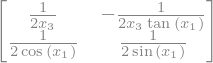

---

In [26]:
M3_nct = sp.Matrix([[1/(2*x3),-1/(2*x3*tan(x1))],[1/(2*cos(x1)),1/(2*sin(x1))]])
M3 = nct.make_all_symbols_commutative(M3_nct, appendix='')[0] ##:

In [27]:
H4 = sp.simplify(M3*H3) ##:

NameError: name 'H3' is not defined

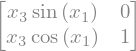

---

In [28]:
M4_nct = sp.Matrix([[x3*sin(x1),0],[x3*cos(x1),1]])
M4 = nct.make_all_symbols_commutative(M4_nct, appendix='')[0] ##:

In [29]:
H5 = sp.simplify(M4*H4) ##:

NameError: name 'H4' is not defined

### Flachheitsnachweis

In [30]:
basis_vec_nct = nct.make_all_symbols_commutative(basis_vec, appendix='')[0]

In [31]:
H5_ = st.col_stack(H5, sp.zeros(2,6))
H5_coeff_omega1 = st.row_split(H5_, 0)[0]
H5_coeff_omega2 = st.row_split(H5_, 1)[0]
omega1 = pc.DifferentialForm(1, basis_vec_nct, coeff=H5_coeff_omega1) ##:
omega2 = pc.DifferentialForm(1, basis_vec_nct, coeff=H5_coeff_omega2) ##:

NameError: name 'H5' is not defined

In [32]:
omega1.d

NameError: name 'omega1' is not defined

In [33]:
omega2.d

NameError: name 'omega2' is not defined

### Berechnung eines flachen Ausgangs

In [34]:
y1 = omega1.integrate() ##

NameError: name 'omega1' is not defined

In [35]:
y2 = omega2.integrate() ##

NameError: name 'omega2' is not defined